In [6]:
import sys

import tensorflow
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import gensim

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Embedding, Bidirectional, Dense, LSTM, Dropout, InputLayer
from tensorflow.python.keras.models import Model
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors #load_word2vec_format
from tqdm import tqdm

num_words = 0

In [7]:
FileName = 'mensaje_limpio.csv'

df = pd.read_csv(FileName,
                 index_col=0,
                 encoding='latin-1')

XBOW = df['mensaje_clean'].values
clases = df['clase'].values

y_tr = np.zeros( (len(clases),1) )
for i in range( len(y_tr) ):
    y_tr[i] = clases[i]


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(XBOW)

In [9]:
def string_to_tensor(string_list):
    string_list = tokenizer.texts_to_sequences(string_list)
    string_list = pad_sequences(string_list, maxlen=max_len)
    
    return string_list

# Creating the padded input for the deep learning model
max_len = np.max([len(text.split()) for text in XBOW])
X_train_tokens = string_to_tensor(XBOW)

print( X_train_tokens.shape )

(382, 23)


In [10]:
def load_word2vec():
    word2vecDict = KeyedVectors.load_word2vec_format(
        #'GoogleNews-vectors-negative300.bin',
        'sbw_vectors.bin',
        binary=True, unicode_errors='ignore')
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
        embeddings_index[word] = word2vecDict.word_vec(word)

    return embeddings_index

In [11]:
tokenizer_obj=Tokenizer()
word_index=tokenizer.word_index
tokenizer.fit_on_texts(XBOW)
sequences=tokenizer_obj.texts_to_sequences(XBOW)

In [12]:
def prepare_matrix(embedding_dict, emb_size=300):
    num_words = len(word_index)
    print(num_words)
    embedding_matrix = np.zeros((num_words+1, emb_size))

    for word, i in tqdm(word_index.items()):
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
      
    return embedding_matrix

In [13]:
def new_model(embedding_matrix, max_len):
    input_dim = len(word_index)
    output_dim = len(embedding_matrix[1])
    
    print( input_dim, output_dim )    
    
    model = Sequential([
        InputLayer(input_shape=(max_len,)),
        Embedding(input_dim+1, output_dim, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(256, return_sequences=True)),
        Bidirectional(LSTM(150)),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")        
    ])

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    return model

In [14]:
embeddings_index=load_word2vec()

C:\Users\Marcos Martinez\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [15]:
embedding_matrix=prepare_matrix(embeddings_index)
embedding_matrix
model=new_model(embedding_matrix, max_len)

1120


100%|██████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 370533.24it/s]

1120 300


In [16]:
X_train, X_test, y_train, y_test = train_test_split( X_train_tokens, y_tr, test_size=0.20, random_state=1)

In [17]:
history = model.fit( X_train, y_train, epochs=20, verbose=2)

Epoch 1/20
10/10 - 2s - loss: 0.6667 - accuracy: 0.5967
Epoch 2/20
10/10 - 3s - loss: 0.4948 - accuracy: 0.8033
Epoch 3/20
10/10 - 2s - loss: 0.4392 - accuracy: 0.8230
Epoch 4/20
10/10 - 2s - loss: 0.3413 - accuracy: 0.8754
Epoch 5/20
10/10 - 3s - loss: 0.2461 - accuracy: 0.8984
Epoch 6/20
10/10 - 3s - loss: 0.2199 - accuracy: 0.9213
Epoch 7/20
10/10 - 2s - loss: 0.1379 - accuracy: 0.9443
Epoch 8/20
10/10 - 3s - loss: 0.2125 - accuracy: 0.9115
Epoch 9/20
10/10 - 3s - loss: 0.0991 - accuracy: 0.9607
Epoch 10/20
10/10 - 2s - loss: 0.0995 - accuracy: 0.9705
Epoch 11/20
10/10 - 2s - loss: 0.1380 - accuracy: 0.9508
Epoch 12/20
10/10 - 3s - loss: 0.0842 - accuracy: 0.9639
Epoch 13/20
10/10 - 3s - loss: 0.0611 - accuracy: 0.9770
Epoch 14/20
10/10 - 3s - loss: 0.0803 - accuracy: 0.9574
Epoch 15/20
10/10 - 2s - loss: 0.0504 - accuracy: 0.9738
Epoch 16/20
10/10 - 3s - loss: 0.0543 - accuracy: 0.9770
Epoch 17/20
10/10 - 3s - loss: 0.0252 - accuracy: 0.9869
Epoch 18/20
10/10 - 3s - loss: 0.0085 - 

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


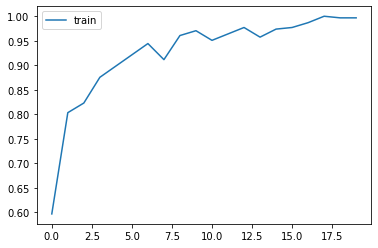

In [18]:
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.legend()
pyplot.show()

In [19]:
no_suicida = ['quiero vivir mucho'] #Clase 0
suicida = ['este es mi segudno intento de suicidio'] #Clase 1

In [20]:
no_suicida_nn = string_to_tensor(no_suicida)
suicida_nn = string_to_tensor(suicida)

In [21]:
p_no_suicida = model.predict(no_suicida_nn)[0][0]
p_suicida = model.predict(suicida_nn)[0][0]

In [22]:
print("No suicida: ", p_no_suicida)
print("Suicida: ", p_suicida)

No suicida:  0.99996173
Suicida:  0.9999964


In [23]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)


# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

#print( yhat_classes )

print(classification_report(y_test, yhat_classes))




Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72        36
         1.0       0.76      0.71      0.73        41

    accuracy                           0.73        77
   macro avg       0.73      0.73      0.73        77
weighted avg       0.73      0.73      0.73        77



In [24]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.727273
Precision: 0.763158
Recall: 0.707317
F1 score: 0.734177
